# MITSUI Commodity Prediction - EDA

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [3]:
# Load datasets
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
labels = pd.read_csv('../data/train_labels.csv')
target_pairs = pd.read_csv('../data/target_pairs.csv')

print('Train shape:', train.shape)
print('Test shape:', test.shape)
print('Labels shape:', labels.shape)
print('Target pairs shape:', target_pairs.shape)

Train shape: (1961, 558)
Test shape: (134, 559)
Labels shape: (1961, 425)
Target pairs shape: (424, 3)


## Explore Train Data

In [4]:
train.head()

,date_id,LME_AH_Close,LME_CA_Close,LME_PB_Close,LME_ZS_Close,JPX_Gold_Mini_Futures_Open,JPX_Gold_Rolling-Spot_Futures_Open,JPX_Gold_Standard_Futures_Open,JPX_Platinum_Mini_Futures_Open,JPX_Platinum_Standard_Futures_Open,...,FX_GBPCAD,FX_CADCHF,FX_NZDCAD,FX_NZDCHF,FX_ZAREUR,FX_NOKGBP,FX_NOKCHF,FX_ZARCHF,FX_NOKJPY,FX_ZARGBP
0,0,2264.5,7205.0,2570.0,3349.0,NaN,NaN,NaN,NaN,NaN,...,1.699987,0.776874,0.888115,0.689954,0.066653,0.090582,0.119630,0.078135,13.822740,0.059163
1,1,2228.0,7147.0,2579.0,3327.0,NaN,NaN,NaN,NaN,NaN,...,1.695279,0.778682,0.889488,0.692628,0.067354,0.091297,0.120520,0.079066,13.888146,0.059895
2,2,2250.0,7188.5,2587.0,3362.0,4684.0,4691.0,4684.0,3363.0,3367.0,...,1.692724,0.780186,0.894004,0.697490,0.067394,0.091478,0.120809,0.079287,13.983675,0.060037
3,3,2202.5,7121.0,2540.0,3354.0,4728.0,4737.0,4729.0,3430.0,3426.0,...,1.683111,0.785329,0.889439,0.698502,0.067639,0.091558,0.121021,0.079285,14.035571,0.059983
4,4,2175.0,7125.0,2604.0,3386.0,NaN,NaN,NaN,NaN,NaN,...,1.684816,0.787264,0.891042,0.701485,0.067443,0.091266,0.121055,0.078925,14.013760,0.059503


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1961 entries, 0 to 1960
Columns: 558 entries, date_id to FX_ZARGBP
dtypes: float64(557), int64(1)
memory usage: 8.3 MB


In [6]:
# Time series columns
ts_cols = [c for c in train.columns if c != 'date_id']
print(f'Number of time series: {len(ts_cols)}')

# Group by prefix
prefixes = {}
for col in ts_cols:
    prefix = col.split('_')[0]
    prefixes[prefix] = prefixes.get(prefix, 0) + 1

print('\nInstruments by exchange:')
for prefix, count in sorted(prefixes.items()):
    print(f'  {prefix}: {count}')

Number of time series: 557

Instruments by exchange:
  FX: 38
  JPX: 40
  LME: 4
  US: 475


## Explore Labels

In [7]:
target_cols = [c for c in labels.columns if c.startswith('target_')]
print(f'Number of targets: {len(target_cols)}')

# Check missing values
missing = labels[target_cols].isnull().sum().sum()
total = labels[target_cols].size
print(f'Missing values: {missing} ({missing/total*100:.2f}%)')

Number of targets: 424
Missing values: 87403 (10.51%)


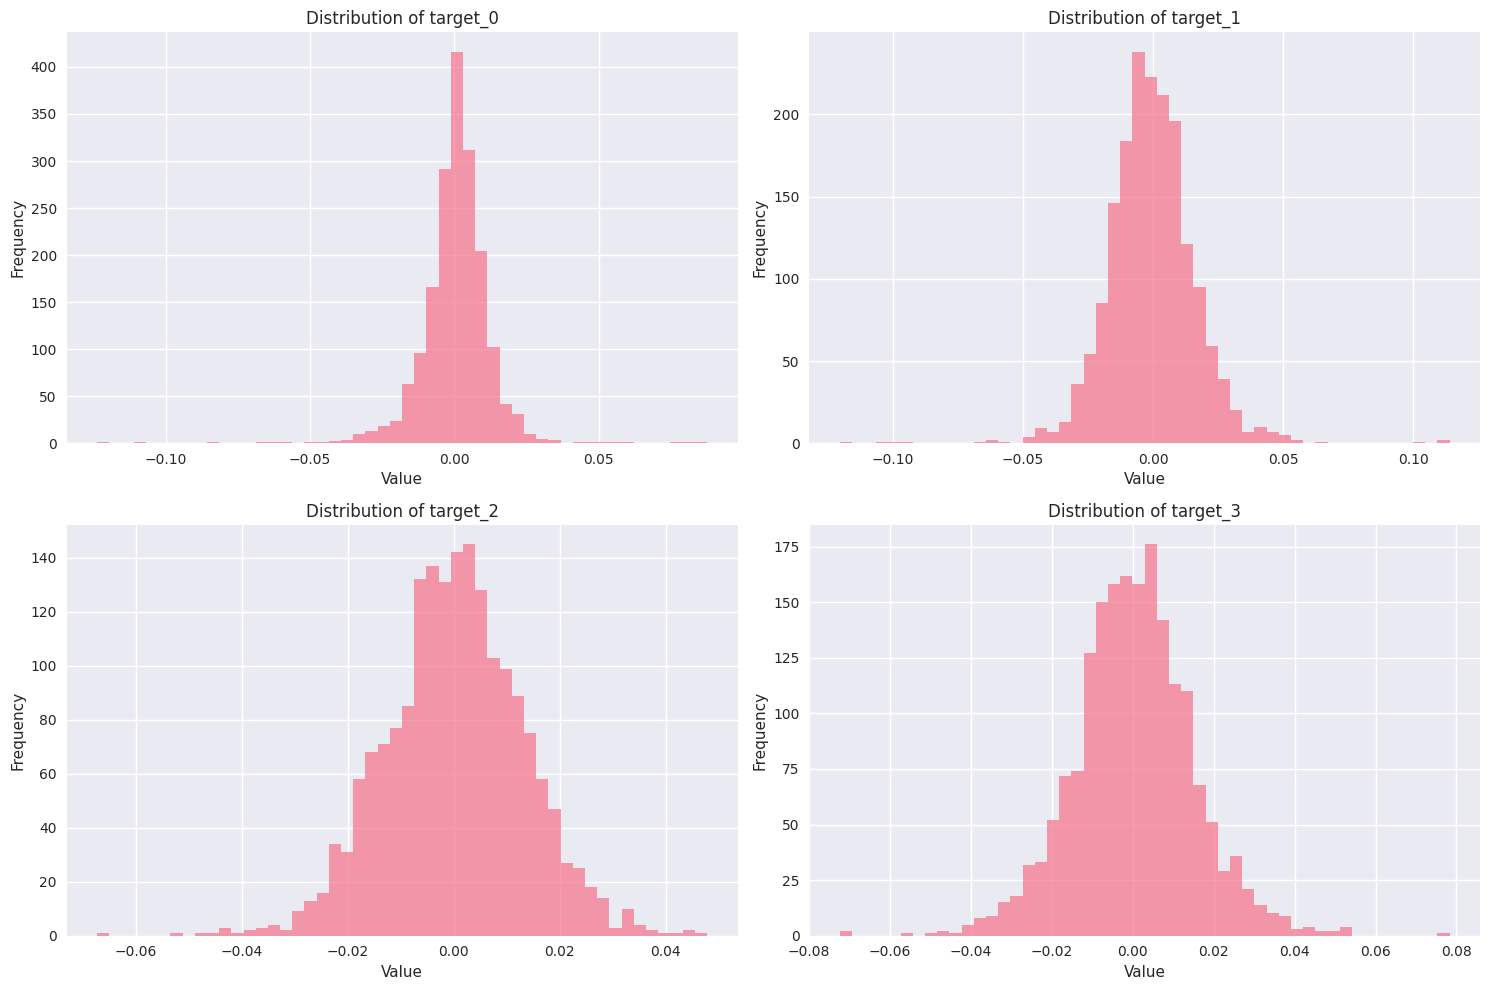

In [8]:
# Distribution of first few targets
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, target in enumerate(target_cols[:4]):
    labels[target].hist(bins=50, ax=axes[i], alpha=0.7)
    axes[i].set_title(f'Distribution of {target}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Target Pairs Analysis

In [9]:
target_pairs.head(10)

,target,lag,pair
0,target_0,1,US_Stock_VT_adj_close
1,target_1,1,LME_PB_Close - US_Stock_VT_adj_close
2,target_2,1,LME_CA_Close - LME_ZS_Close
3,target_3,1,LME_AH_Close - LME_ZS_Close
4,target_4,1,LME_AH_Close - JPX_Gold_Standard_Futures_Close
5,target_5,1,LME_ZS_Close - JPX_Platinum_Standard_Futures_C...
6,target_6,1,LME_PB_Close - LME_AH_Close
7,target_7,1,LME_ZS_Close - US_Stock_VYM_adj_close
8,target_8,1,US_Stock_IEMG_adj_close - JPX_Gold_Standard_Fu...
9,target_9,1,FX_AUDJPY - LME_PB_Close


Targets by lag:
lag
1    106
2    106
3    106
4    106
Name: count, dtype: int64


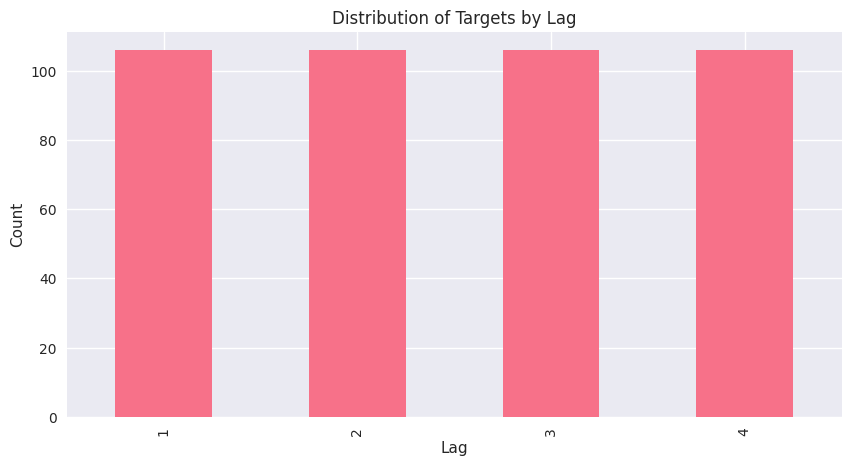

In [10]:
# Lag distribution
print('Targets by lag:')
print(target_pairs['lag'].value_counts().sort_index())

# Visualize
target_pairs['lag'].value_counts().sort_index().plot(kind='bar', figsize=(10, 5))
plt.title('Distribution of Targets by Lag')
plt.xlabel('Lag')
plt.ylabel('Count')
plt.show()

## Time Series Visualization

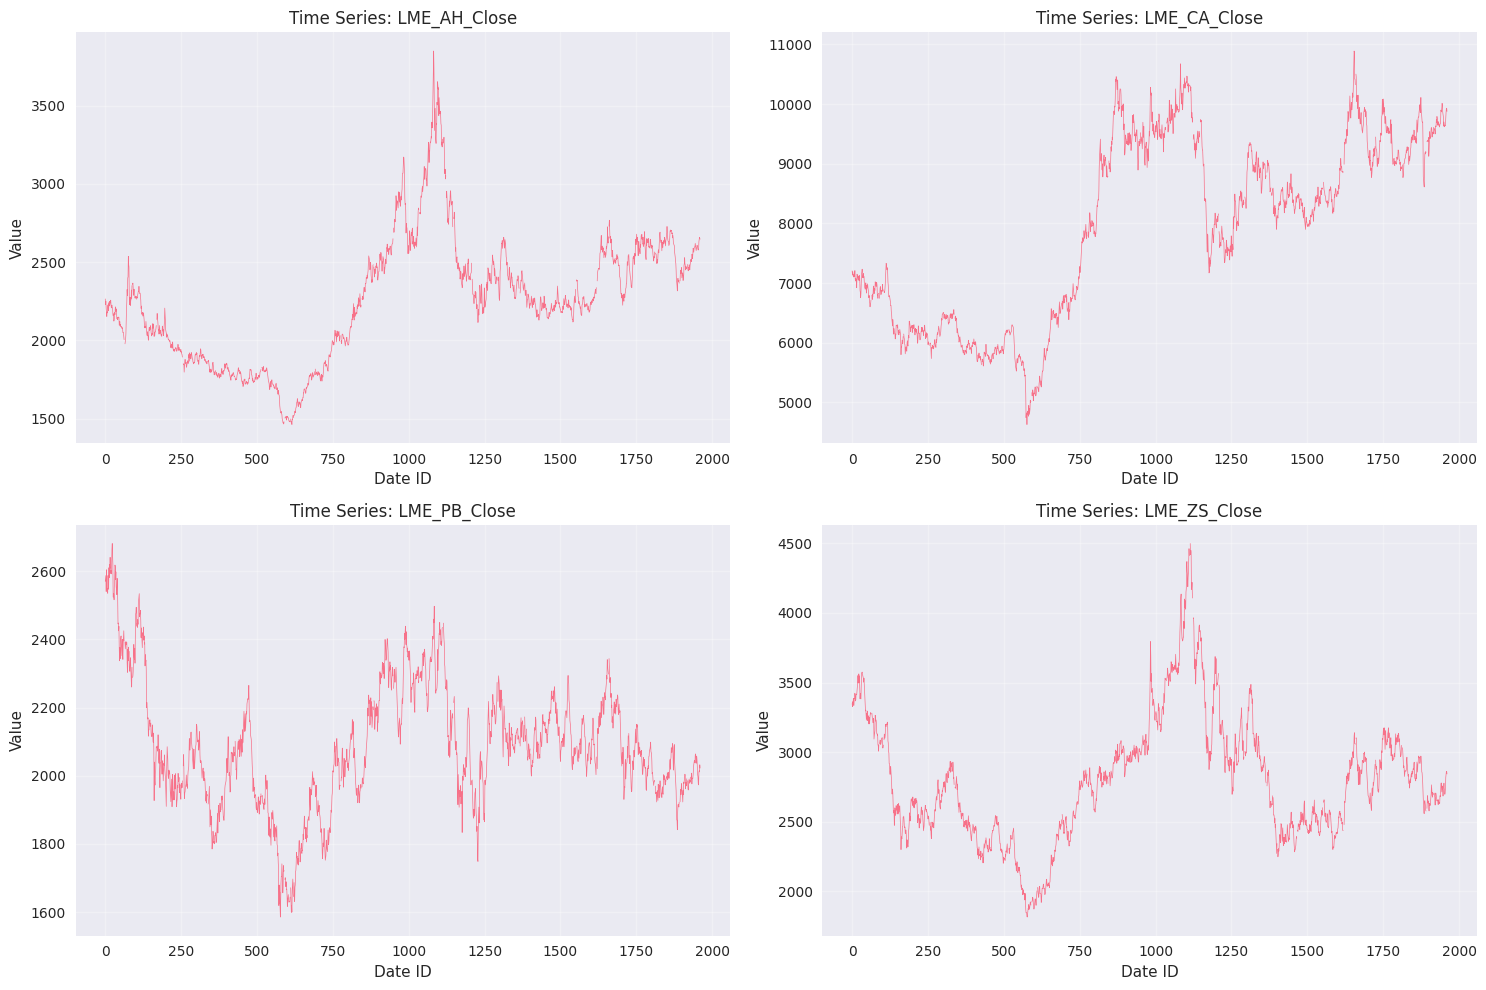

In [11]:
# Plot a few time series
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

sample_cols = ts_cols[:4]
for i, col in enumerate(sample_cols):
    axes[i].plot(train['date_id'], train[col], linewidth=0.5)
    axes[i].set_title(f'Time Series: {col}')
    axes[i].set_xlabel('Date ID')
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Next Steps

1. Feature engineering (lags, rolling stats, technical indicators)
2. Baseline model (simple LSTM or GradientBoosting)
3. Deep learning models (Transformer, TFT)
4. Ensemble